# Construction of Training, Validation and Testing Data
***

### 1. Importing and Installing Packages
***


In [ ]:
!pip install lungs-segmentation

In [57]:
from lungs_segmentation.pre_trained_models import create_model
from sklearn.model_selection import train_test_split
import lungs_segmentation.inference as inference
from bbox_delimiters import bbox_utils
import matplotlib.pyplot as plt
import urllib.request as url
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib
import random
import shutil
import torch
import cv2

### 2. Preparing Training Data
***

- [Reference Data - Obtained from Kaggle](https://www.kaggle.com/willarevalo/chexpert-v10-small)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

!cp /content/gdrive/MyDrive/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

In [ ]:
dataframe = pd.read_csv('/content/CheXpert-v1.0-small/train.csv', delimiter = ',')

dataframe = dataframe[dataframe['Frontal/Lateral'] == 'Frontal']

dataframe = dataframe[(dataframe['AP/PA'] == 'AP') |
                      (dataframe['AP/PA'] == 'PA')]

In [ ]:
path_files = np.array(dataframe['Path']).astype(str)
model = bbox_utils().model_segmentation(archictecture = 'resnet34')

In [38]:
coordinates = list()
for images in path_files:
  image, mask = bbox_utils().make_segmentation(model = model, path_image = images)
  original_mask = bbox_utils().join_masks(lung_left = mask[0], lung_right = mask[1])
  contours = bbox_utils().get_contours(mask = original_mask.copy(), erode_radius = 10)
  mask_contours = bbox_utils().draw_contours(contours = bbox_utils().find_two_best_areas(contours = contours), 
                                             image_shape = image.shape, dilate_radius = 6)
  list_coordinates = bbox_utils().extract_coordinates(mask = mask_contours, list_of_margins = [8, 8, 20, 8])
  coordinates.append(list_coordinates)

coordinates = np.array(coordinates)

In [40]:
dataframe = pd.DataFrame(path_files, columns = ['Path'])
dataframe['p1_x'] = coordinates[:, 0]
dataframe['p1_y'] = coordinates[:, 1]
dataframe['p2_x'] = coordinates[:, 2]
dataframe['p2_y'] = coordinates[:, 3]

dataframe.to_csv('csv-data/lung_localization_chexpert.csv')

In [41]:
dataframe.head(10)

,Path,p1_x,p1_y,p2_x,p2_y
0,CheXpert-v1.0-small/train/patient00001/study1/...,0.109375,0.190625,0.756250,0.906250
1,CheXpert-v1.0-small/train/patient00002/study2/...,0.075000,0.162500,0.640625,0.871875
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.000000,0.196875,0.515625,0.812500
3,CheXpert-v1.0-small/train/patient00003/study1/...,0.065625,0.062500,0.859375,0.853125
4,CheXpert-v1.0-small/train/patient00004/study1/...,0.053125,0.156250,0.965625,0.900000
5,CheXpert-v1.0-small/train/patient00005/study1/...,0.059375,0.103125,0.843750,0.896875
6,CheXpert-v1.0-small/train/patient00005/study2/...,0.018750,0.187500,0.700000,0.834375
7,CheXpert-v1.0-small/train/patient00005/study2/...,0.059375,0.162500,0.878125,0.865625
8,CheXpert-v1.0-small/train/patient00006/study1/...,0.165625,0.078125,1.000000,0.987500
9,CheXpert-v1.0-small/train/patient00007/study1/...,0.109375,0.206250,0.806250,0.953125


## 3. Separating the dataset into Training, Validation and Testing
***

In [50]:
train_df, test_df = train_test_split(dataframe, train_size = 0.8, random_state = 42, shuffle = True)
test_df, val_df = train_test_split(test_df, train_size = 0.5, random_state = 42, shuffle = True)
val_df, plot_df = train_test_split(val_df, train_size = 0.9974, random_state = 42, shuffle = True)

In [52]:
print('Number of Training Images: {} images'.format(len(train_df)))
print('Number of Validation Images: {} images'.format(len(val_df)))
print('Number of Test Images: {} images'.format(len(test_df)))
print('Number of Plot Images: {} images'.format(len(plot_df)))

Number of Training Images: 152808 images
Number of Validation Images: 19051 images
Number of Test Images: 19101 images
Number of Plot Images: 50 images


In [53]:
train_df.to_csv('csv-data/train-data.csv')
val_df.to_csv('csv-data/val-data.csv')
test_df.to_csv('csv-data/test-data.csv')
plot_df.to_csv('csv-data/plot-data-chexpert.csv')

## 4. Viewing Data
***

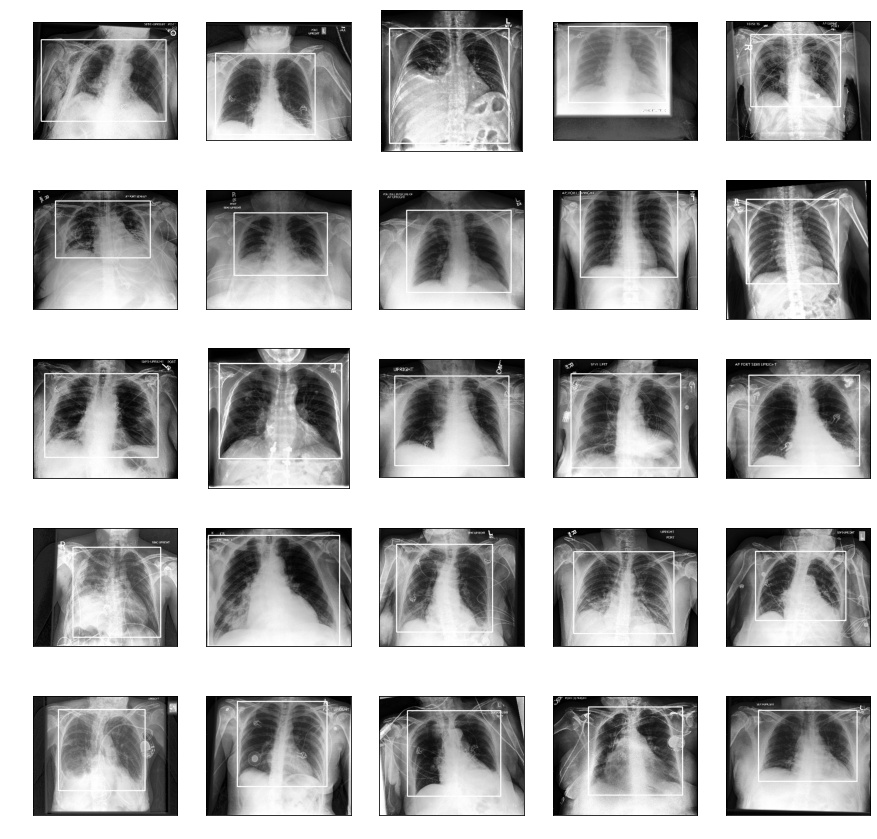

In [59]:
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (15, 15))
for i in range(0, 5):
  for j in range(0, 5):
    count = random.randrange(0, len(coordinates))
    image = bbox_utils().draw_rectangle(image = plt.imread(path_files[count]), 
                                        list_coordinates = coordinates[count])
    axs[i][j].imshow(image, cmap = 'gray', vmin = np.min(image), vmax = np.max(image))

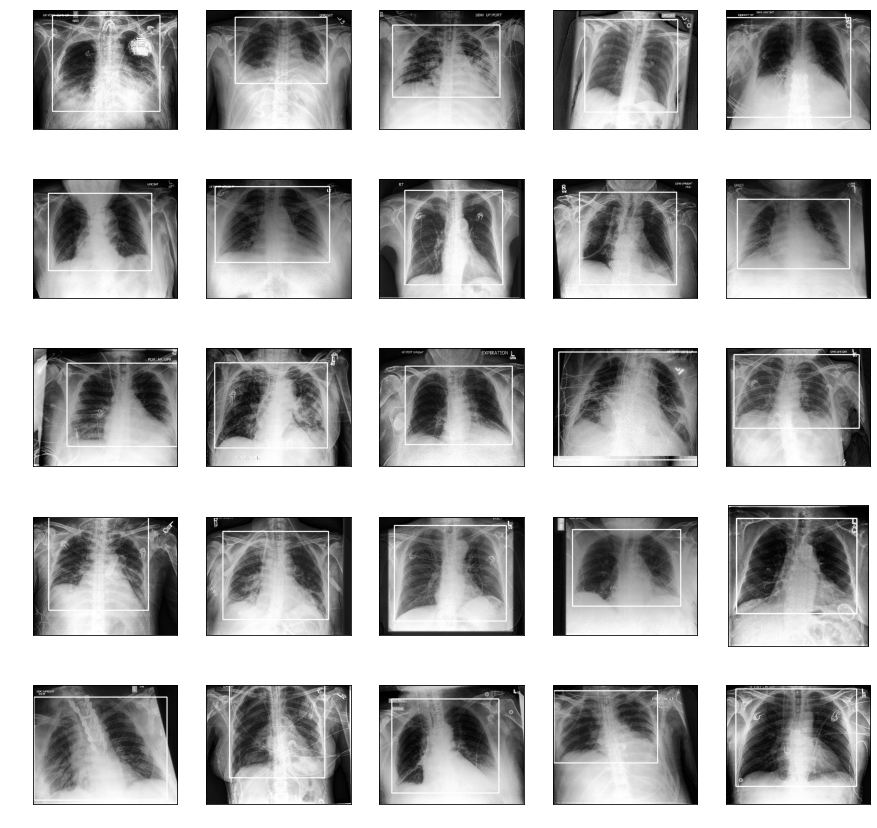

In [60]:
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (15, 15))
for i in range(0, 5):
  for j in range(0, 5):
    count = random.randrange(0, len(coordinates))
    image = bbox_utils().draw_rectangle(image = plt.imread(path_files[count]), 
                                        list_coordinates = coordinates[count])
    axs[i][j].imshow(image, cmap = 'gray', vmin = np.min(image), vmax = np.max(image))